# One-step prediction of Labe flow

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
# import tensorboard as tb
import numpy as np
import scipy.io as sio # for working with .mat files
import matplotlib.pyplot as plt # for plotting the data
from datetime import datetime # for keeping separate TB logs for each run

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [16]:
# define unique name for log directory
now = datetime.now()
logdir = "./logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

# define constants
input_size = 1
batch_size = 5
num_units = 64 # hidden state vector size in LSTM cell
num_classes = 1 # output size (only one specific value)
target_shift = 1 # the target is the same time-series shifted by 1 time-step forward
delay = 5 # the number of time-steps from which we are going to predict the next step
n_epochs = 200 # number of epochs

# decaying learning rate constants (for exponential decay)
initial_learning_rate = 0.001 # initial learning rate for Adam training algorithm
decay_steps = n_epochs//10 # every "n_epochs//10" epochs the learning rate is reduced
decay_rate = 0.96 # the base of the exponential (rate of the decay)

In [3]:
# load data from Q.mat
data = sio.loadmat('Q.MAT') # samples were gathered with period of one week

# convert to np array
data = np.array(data['Q'],dtype=np.float32)

# normalize the data to interval (0,1)
data = np.divide(np.subtract(data,np.min(data)),np.subtract(np.max(data),np.min(data))).flatten()

In [4]:
# divide the data into training, testing and validation part
end_of_train = round(0.7*len(data))
end_of_test = round(end_of_train + 0.15*len(data))

x_train = data[:end_of_train]
x_test = data[end_of_train:end_of_test]
x_validation = data[end_of_test:]

# define the shifted time-series (targets)
y_train = np.roll(x_train, target_shift)
y_test = np.roll(x_test, target_shift)
y_validation = np.roll(x_validation, target_shift)

# delete the first elements of the time series that were reintroduced from the end of the timeseries
y_train[:target_shift] = 0
y_test[:target_shift] = 0
y_validation[:target_shift] = 0

In [5]:
# reset TensorFlow graph
tf.reset_default_graph()

# define output weights and biases
with tf.name_scope("output_layer"):
    weights_out = tf.Variable(tf.random_normal([num_units,num_classes]),name='weights_out')
    bias_out = tf.Variable(tf.random_normal([num_classes]),name='biases_out')
    
# define histogram summaries for output weights (for visualization in TensorBoard)
tf.summary.histogram("w_out_summary", weights_out)

# define placeholders for the batches of time-series
x = tf.placeholder(tf.float32,[None, delay, input_size],name='x') # batch of inputs
y = tf.placeholder(tf.float32,[None, num_classes],name='y') # batch of labels

In [6]:
# processing the input tensor from [batch_size,delay,input_size] to "delay" number of [batch_size,input_size] tensors
input=tf.unstack(x ,delay,1,name='LSTM_input_list') # create list of values by unstacking one dimension

In [7]:
# define a one LSTM unit network
with tf.name_scope("LSTM_layer"):
    lstm_cell = rnn.LSTMCell(num_units) # basic lstm cell with num_units hidden state size
    # add dropout to the inputs and outputs of the LSTM cell (reduces overfitting)
    lstm_dropout = rnn.DropoutWrapper(lstm_cell, input_keep_prob=0.5, output_keep_prob=0.5, state_keep_prob=1.0)
    outputs,_ = rnn.static_rnn(lstm_dropout, input, dtype=tf.float32)

In [8]:
# generate prediction based on the last time-step output (one-step prediction)
prediction = tf.matmul(outputs[-1],weights_out) + bias_out

In [9]:
# define loss function
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
with tf.name_scope("loss"):
    loss = tf.sqrt(tf.losses.mean_squared_error(predictions=prediction,labels=y))
    # define scalar summary for TensorBoard visualization of loss
    tf.summary.scalar("loss",loss)

# exponential decay of learning rate with epochs
global_step = tf.Variable(1, trainable=False, name='global_step') # variable that keeps track of the step at which we are in the training
increment_global_step_op = tf.assign(global_step, global_step+1,name='increment_global_step') # operation that increments global step by one
# decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                           decay_steps, decay_rate, staircase=True) # decay at discrete intervals

# define Adam optimizer for training of the network
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [17]:
# RUNNING THE NETWORK

# initializer of TF variables
init = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# number of iterations in each epoch
n_iter = int(np.rint((len(x_train)-delay)//batch_size)) # round to nearest integer
n_iter_test = int(np.rint((len(x_test)-delay)//batch_size))
n_iter_validation = int(np.rint((len(x_validation)-delay)//batch_size))

# function for generating the time-series batches
def create_batch(x_data,y_data,batch_size,delay,input_size,index):
    
    x_batch = np.zeros([batch_size,delay,input_size])
    y_batch = np.zeros([batch_size,num_classes])
    
    for i in range(batch_size):
        x_batch[i,:,:] = np.reshape(x_data[index*batch_size+i:index*batch_size+i+delay],(delay,num_classes))
        y_batch[i,:] = np.reshape(y_data[index*batch_size+delay+i+1],(1,num_classes))
        
    return x_batch, y_batch

# merge the summaries of all tf.summary calls (for TensorBoard visualization)
merged = tf.summary.merge_all()

def run_model(inputs,labels,n_iter,train=False):
      
    prediction_list = [] # list for prediction results
    loss_val_sum = 0 # sum of the loss function throughout the whole data
    
    for i in range(n_iter):
        # training batch
        x_batch, y_batch = create_batch(inputs,labels,batch_size,delay,input_size,i)

        feed_dict = {x: x_batch, y: y_batch}
        
        # train the net on the data
        if train:
            session.run(optimizer,feed_dict=feed_dict) # run the optimization on the current batch

        loss_val, prediction_val = session.run((loss, prediction), feed_dict=feed_dict)

        loss_val_sum += loss_val # sum the losses across the batches
        
        summary = session.run(merged, feed_dict=feed_dict)
        
        # on the last epoch
        if epoch == n_epochs - 1:       
            # save the batch predictions to a list
            prediction_list.extend(prediction_val)
            
    return loss_val_sum, prediction_list, summary
    
with tf.Session() as session:
    # Create a SummaryWriter to output summaries and the Graph
    # in console run 'tensorboard --logdir=./logs/'
    summary_writer = tf.summary.FileWriter(logdir=logdir, graph=session.graph)
    
    session.run(init) # initialize variables
    
    for epoch in range(n_epochs):
        # TRAINING
        loss_val, prediction_list, _ = run_model(x_train,y_train,n_iter,train=True)
        
        # TESTING
        loss_val_test, prediction_list_test, summary_test = run_model(x_test,y_test,n_iter_test,train=False)
            
        # increment global step for decaying learning rate at each epoch
        session.run(increment_global_step_op)

        # Printing the results at every "n_epochs//10" epochs
        if epoch % (n_epochs//10) == 0:
            print("Epoch: {}".format(epoch))
            print("TRAINING Loss: {}".format(loss_val))
            print("TESTING Loss: {}".format(loss_val_test))
            print("____________________________")
            # write the summaries of testing data at epoch in TensorBoard
            summary_writer.add_summary(summary_test, epoch)
            summary_writer.flush()
        
    # run the trained net on VALIDATION time-series
    loss_val_validation, prediction_list_validation, _ = run_model(x_validation,y_validation,n_iter_validation,train=False)
            
    print("VALIDATION Loss: {}".format(loss_val_validation))
    
    # save the trained net and variables for later use
    saver.save(session, './checkpoints/LSTMforPredictingLabeFlow')

Epoch: 0
TRAINING Loss: 9.888018977595493
TESTING Loss: 0.10532027139561251
____________________________
Epoch: 20
TRAINING Loss: 0.41074187454069033
TESTING Loss: 0.047200103086652234
____________________________
Epoch: 40
TRAINING Loss: 0.33750582128413953
TESTING Loss: 0.05106554366648197
____________________________
Epoch: 60
TRAINING Loss: 0.32056473652482964
TESTING Loss: 0.053930958558339626
____________________________
Epoch: 80
TRAINING Loss: 0.315777796698967
TESTING Loss: 0.054533351823920384
____________________________
Epoch: 100
TRAINING Loss: 0.3093456536589656
TESTING Loss: 0.0547314646828454
____________________________
Epoch: 120
TRAINING Loss: 0.302686881943373
TESTING Loss: 0.055100844852859154
____________________________
Epoch: 140
TRAINING Loss: 0.2988111149170436
TESTING Loss: 0.05557403826969676
____________________________
Epoch: 160
TRAINING Loss: 0.2935178558691405
TESTING Loss: 0.05607274858630262
____________________________
Epoch: 180
TRAINING Loss: 0.288

In [18]:
# Shift the predictions "delay" time-steps to the right
prediction_train = np.array(prediction_list)
prediction_test = np.array(prediction_list_test)
prediction_validation = np.array(prediction_list_validation)

prediction_train = np.pad(prediction_train,pad_width=((delay,0),(0,0))
                          ,mode='constant',constant_values=0) # pad with "delay" zeros at the start of first dimension
prediction_test = np.pad(prediction_test,pad_width=((delay,0),(0,0))
                          ,mode='constant',constant_values=0) # pad with "delay" zeros at the start of first dimension
prediction_validation = np.pad(prediction_validation,pad_width=((delay,0),(0,0))
                          ,mode='constant',constant_values=0) # pad with "delay" zeros at the start of first dimension

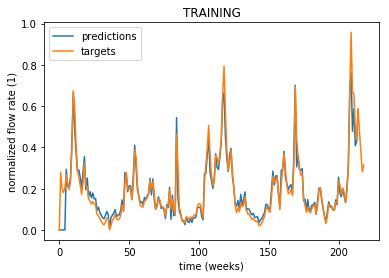

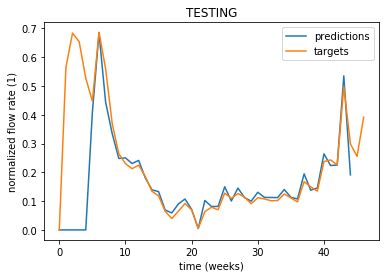

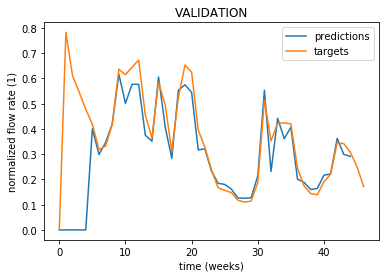

In [19]:
# Plot the results
def plot_results(predictions, targets):
    plt.plot(predictions)
    plt.plot(targets)
    plt.xlabel('time (weeks)')
    plt.ylabel('normalized flow rate (1)')
    plt.legend(['predictions', 'targets'])
    plt.draw()

plt.figure()
plot_results(prediction_train, y_train)
plt.title('TRAINING')

plt.figure()
plot_results(prediction_test, y_test)
plt.title('TESTING')

plt.figure()
plot_results(prediction_validation, y_validation)
plt.title('VALIDATION')
plt.show()

## Following cells are for debugging purposes

In [13]:
x_batch, y_batch = create_batch(x_train,y_train,batch_size,delay,input_size,1)

print(np.shape(x_batch),np.shape(y_batch))
print(x_batch, y_batch)

(5, 5, 1) (5, 1)
[[[0.21870252]
  [0.19578202]
  [0.22910184]
  [0.38448831]
  [0.67414039]]

 [[0.19578202]
  [0.22910184]
  [0.38448831]
  [0.67414039]
  [0.60189325]]

 [[0.22910184]
  [0.38448831]
  [0.67414039]
  [0.60189325]
  [0.41667622]]

 [[0.38448831]
  [0.67414039]
  [0.60189325]
  [0.41667622]
  [0.29206336]]

 [[0.67414039]
  [0.60189325]
  [0.41667622]
  [0.29206336]
  [0.25559574]]] [[0.60189325]
 [0.41667622]
 [0.29206336]
 [0.25559574]
 [0.2180347 ]]


In [14]:
## TODO:
# - test and validation --- DONE
# - drift??? --- DONE
# - Variable length last batch to make use of all the available data!!!
# - Show the graph in TensorBoard

decayed_learning_rate_test = 0.01 * 0.90 ** (2000 / 1000)
print(decayed_learning_rate_test)

0.008100000000000001


In [15]:
print(x_batch)
print('______')
print(y_batch)

print('\n ___batch 2___ \n')
x_batch, y_batch = create_batch(x_train,y_train,2,4,input_size,2)

print(x_batch)
print('______')
print(y_batch)

print('\n ___batch 3___ \n')
x_batch, y_batch = create_batch(x_train,y_train,2,4,input_size,3)

print(x_batch)
print('______')
print(y_batch)

# FIXED: with every batch we jumped over one value while generating batches

[[[0.21870252]
  [0.19578202]
  [0.22910184]
  [0.38448831]
  [0.67414039]]

 [[0.19578202]
  [0.22910184]
  [0.38448831]
  [0.67414039]
  [0.60189325]]

 [[0.22910184]
  [0.38448831]
  [0.67414039]
  [0.60189325]
  [0.41667622]]

 [[0.38448831]
  [0.67414039]
  [0.60189325]
  [0.41667622]
  [0.29206336]]

 [[0.67414039]
  [0.60189325]
  [0.41667622]
  [0.29206336]
  [0.25559574]]]
______
[[0.60189325]
 [0.41667622]
 [0.29206336]
 [0.25559574]
 [0.2180347 ]]

 ___batch 2___ 

[[[0.2662805 ]
  [0.21870252]
  [0.19578202]
  [0.22910184]]

 [[0.21870252]
  [0.19578202]
  [0.22910184]
  [0.38448831]]]
______
[[0.38448831]
 [0.67414039]]

 ___batch 3___ 

[[[0.19578202]
  [0.22910184]
  [0.38448831]
  [0.67414039]]

 [[0.22910184]
  [0.38448831]
  [0.67414039]
  [0.60189325]]]
______
[[0.60189325]
 [0.41667622]]
